# Normal Model with 1D GP Priors and Synthetic Data

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

import matplotlib.pyplot as plt
import pandas as pd
import torch
from utils import generate_data, match

from famo.core import CORE

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
import seaborn as sns

## Data Generation

In [2]:
factor_smoothness = {"group_1" : [0.9, 0.9, 0.1, 0.9, 0.9, 0.1, 0.9, 0.9, 0.1, 0.9], "group_2" : [0.1, 0.9, 0.1, 0.1, 0.9, 0.1, 0.1, 0.9, 0.1, 0.9]}

data = generate_data(
    n_samples={"group_1" : 200, "group_2" : 270},
    n_features={"view_1" : 400, "view_2" : 600},
    n_factors=10,
    likelihoods={"view_1" : "Normal", "view_2" : "Normal"},
    covariates={"group_1" : torch.rand(200, 1), "group_2" : torch.rand(270, 1)},
    factor_smoothness=factor_smoothness,
)

/Users/chigurh/miniconda3/envs/famo_dev/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/chigurh/miniconda3/envs/famo_dev/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [3]:
sns.heatmap(data["group_1"]["view_1"].varm["w"] > 0.05)

Setting up device...
- No device id given. Using default device: 0
- Running all computations on `cuda:0`
- No likelihoods provided. Inferring likelihoods from data.
  - view_1: Normal
  - view_2: Normal
- Centering group_1/view_1...
- Centering group_1/view_2...
- Centering group_2/view_1...
- Centering group_2/view_2...


/data/walter/famo/src/famo/utils_data.py:278: RuntimeWarning: Mean of empty slice
  means[k_groups][k_views] = np.nanmean(v_views.X, axis=0)


<Axes: >

<Figure size 640x480 with 2 Axes>

In [5]:
assert (data["group_1"]["view_1"].varm["w_mask"] == data["group_2"]["view_1"].varm["w_mask"]).all()

In [6]:
model = CORE(device="cuda")
model.fit(
    data=data,
    # n_factors=10,
    annotations={"view_1": data["group_1"]["view_1"].varm["w_mask"].T, "view_2": data["group_2"]["view_2"].varm["w_mask"].T},
    factor_prior="GP",
    weight_prior="Horseshoe",
    covariates_obsm_key="x",
    prior_penalty=0.01,
    lr=0.005,
    early_stopper_patience=500,
    print_every=500,
    plot_data_overview=False,
    center_groups=True,
    scale_views=False,
    scale_groups=True,
    max_epochs=1000,
    init_factors="random",
    init_scale=0.1,
    save=False,
)

Setting up device...
- `cuda` not available...
- Running all computations on `cpu`
- No likelihoods provided. Inferring likelihoods from data.
  - view_1: Normal
  - view_2: Normal
- Centering group_1/view_1...
- Centering group_1/view_2...
- Centering group_2/view_1...
- Centering group_2/view_2...
Initializing factors using `random` method...
Decaying learning rate over 1000 iterations.
Setting training seed to `2409171943`.
Cleaning parameter store.
Epoch:       0 | Time:       1.44s | Loss:     119.23
Epoch:      50 | Time:       3.49s | Loss:      91.04
Epoch:     100 | Time:       5.51s | Loss:      74.72
Epoch:     150 | Time:       7.58s | Loss:      58.04
Epoch:     200 | Time:       9.62s | Loss:      46.71
Epoch:     250 | Time:      11.75s | Loss:      37.04
Epoch:     300 | Time:      13.92s | Loss:      29.65
Epoch:     350 | Time:      16.02s | Loss:      25.49
Epoch:     400 | Time:      18.12s | Loss:      18.24
Epoch:     450 | Time:      20.32s | Loss:       8.77
Epo

## Assignment of Inferred to True Factors

In [4]:
def get_gp_mean_std(model, group, x, n_samples=500):
    gp = model.gps[group]
    samples = gp(x.to(model.device), prior=False).sample(torch.Size([n_samples]))
    mean = samples.mean(axis=0).cpu().detach().numpy()
    std = samples.std(axis=0).cpu().detach().numpy()

    return mean, std

x = torch.arange(0, 1, 0.01)

covariates = {}

w = {}
z = {}
outputscales = {}
f_mean = {}
f_std = {}

w_gt = {}
z_gt = {}
f_gt = {}

inds = {}
signs = {}

for group in model.group_names:
    z[group] = model.get_factors("pandas")[group]
    outputscales[group] = model.gps[group].covar_module.outputscale.cpu().detach().numpy()[model.factor_order]
    f_mean[group], f_std[group] = get_gp_mean_std(model, group, x)
    f_mean[group] = f_mean[group][model.factor_order]
    f_std[group] = f_std[group][model.factor_order]
    covariates[group] = pd.DataFrame(model.covariates[group], index=z[group].index)

    z_gt[group] = pd.DataFrame(data[group][model.view_names[0]].obsm["z"], index=data[group][model.view_names[0]].obs_names)
    f_gt[group] = pd.DataFrame(data[group][model.view_names[0]].obsm["f"], index=data[group][model.view_names[0]].obs_names)

    z_common_indices = z[group].index.intersection(z_gt[group].index)
    z[group] = z[group].loc[z_common_indices].sort_index(axis=0)
    z_gt[group] = z_gt[group].loc[z_common_indices].sort_index(axis=0)
    f_gt[group] = f_gt[group].loc[z_common_indices].sort_index(axis=0)
    covariates[group] = covariates[group].loc[z_common_indices].sort_index(axis=0)

    inds[group], signs[group] = match(z_gt[group].values, z[group].values, dim=-1)
    z[group] = z[group].iloc[:, inds[group]] * signs[group]
    f_mean[group] = f_mean[group][inds[group]] * signs[group].reshape(-1, 1)
    f_std[group] = f_std[group][inds[group]] * signs[group].reshape(-1, 1)
    outputscales[group] = outputscales[group][inds[group]]

for view in model.view_names:
    w[view] = model.get_weights("pandas")[view]
    w_gt[view] = pd.DataFrame(data[group][view].varm["w"].T, columns=data[group][view].var_names)

    w_common_cols = w[view].columns.intersection(w_gt[view].columns)
    w[view] = w[view].loc[:, w_common_cols].sort_index(axis=1)
    w_gt[view] = w_gt[view].loc[:, w_common_cols].sort_index(axis=1)

    w[view] = w[view].iloc[inds[model.group_names[0]]] * signs[model.group_names[0]].reshape(-1, 1)

## Correlation Plots

### Factor Scores

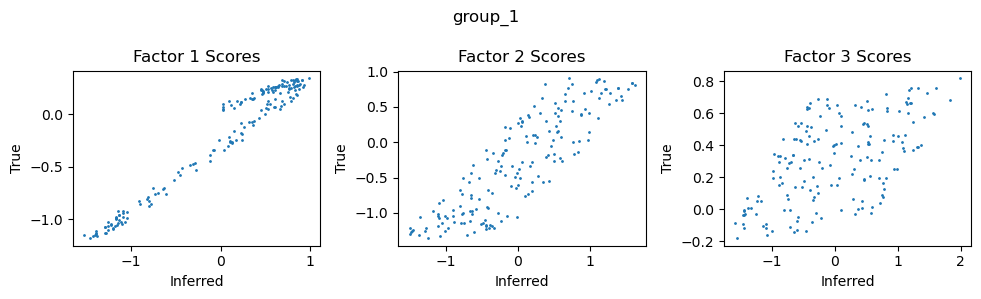

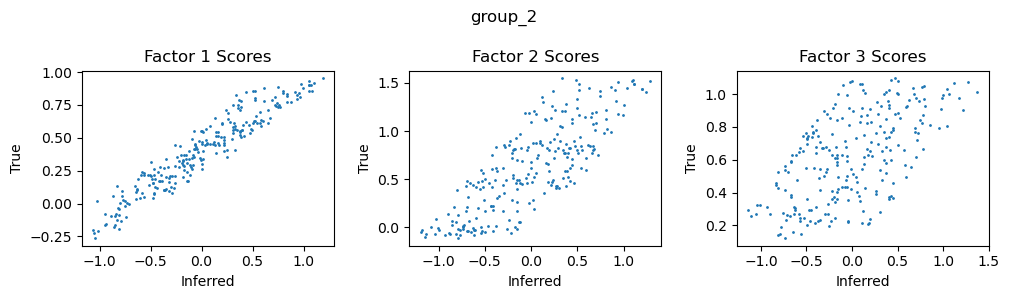

In [5]:
for group in model.group_names:
    fig, axs = plt.subplots(1, z[group].shape[1], figsize=(20, 3))
    for i in range(z[group].shape[1]):
        axs[i].scatter(z[group].iloc[:, i], z_gt[group].iloc[:, i], s=1)
        axs[i].set_title(f"Factor {i + 1} Scores")

    for ax in axs.flatten():
        ax.set_xlabel("Inferred")
        ax.set_ylabel("True")

    fig.suptitle(group)
    plt.tight_layout()

### Factor Loadings

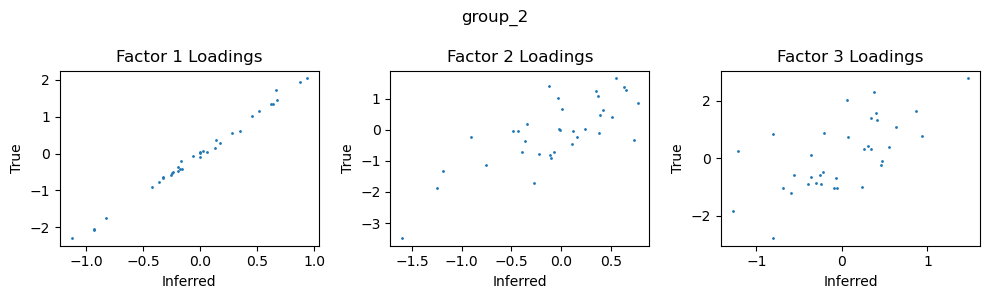

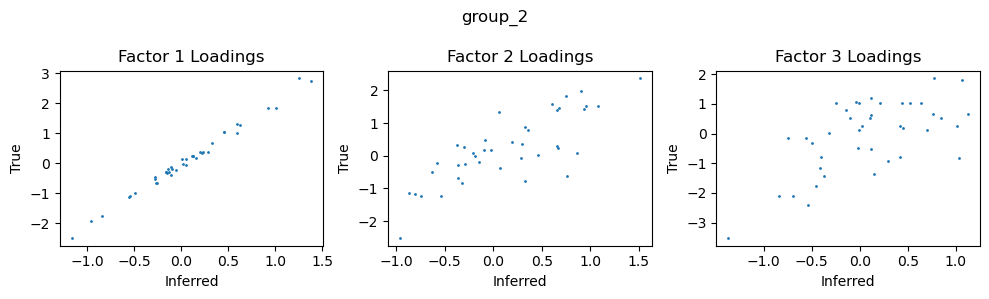

In [6]:
for view in model.view_names:
    fig, axs = plt.subplots(1, w[view].shape[0], figsize=(20, 3))
    for i in range(w[view].shape[0]):
        axs[i].scatter(w[view].iloc[i], w_gt[view].iloc[i], s=1)
        axs[i].set_title(f"Factor {i + 1} Loadings")

    for ax in axs.flatten():
        ax.set_xlabel("Inferred")
        ax.set_ylabel("True")

    fig.suptitle(view)
    plt.tight_layout()

## Factor - Covariate Plots

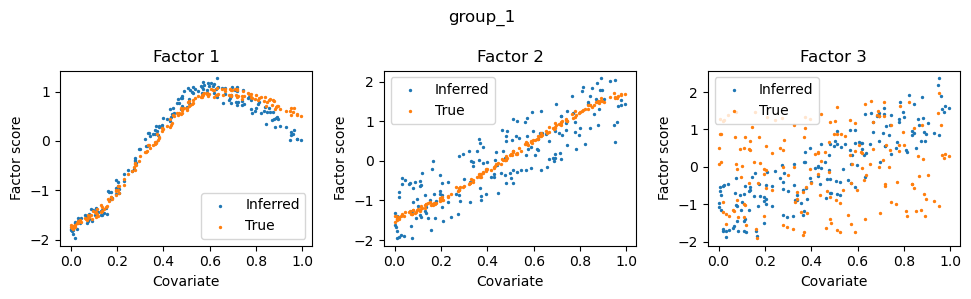

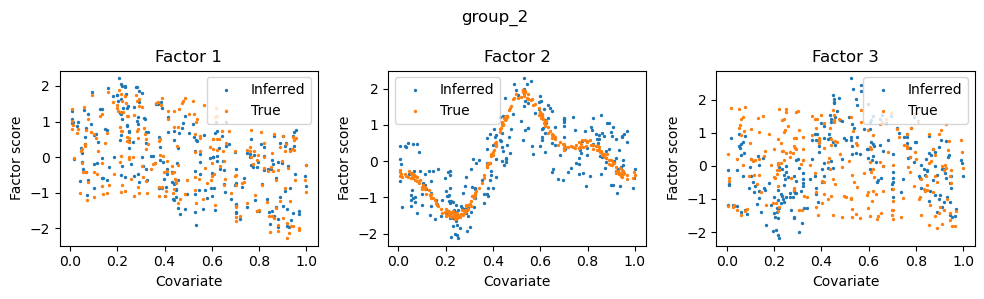

In [7]:
for group in model.group_names:
    fig, axs = plt.subplots(1, z[group].shape[1], figsize=(20, 3))
    for i in range(model.n_factors):
        z_gt_normalized = (z_gt[group].iloc[:, i] - z_gt[group].iloc[:, i].mean()) / z_gt[group].iloc[:, i].std()
        z_normalized = (z[group].iloc[:, i] - z[group].iloc[:, i].mean()) / z[group].iloc[:, i].std()
        axs[i].scatter(covariates[group], z_normalized, c="C0", s=2, label="Inferred")
        axs[i].scatter(covariates[group], z_gt_normalized, c="C1", s=2, label="True")
        axs[i].set_xlabel("Covariate")
        axs[i].set_ylabel("Factor score")
        axs[i].set_title(f"Factor {i+1}")
        axs[i].legend()
    fig.suptitle(group)
    plt.tight_layout()

In [8]:
def plot_gp(x, mean, std, ax=None):
    lower_bound = mean - 1.96 * std
    upper_bound = mean + 1.96 * std

    if ax is None:
        plt.figure(figsize=(10, 5))
        plt.plot(x, mean, 'b-', label='Mean')
        plt.fill_between(x, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.show()

    else:
        ax.plot(x, mean, color="C0", label='Mean')
        ax.fill_between(x, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% CI')
        ax.legend()
        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")

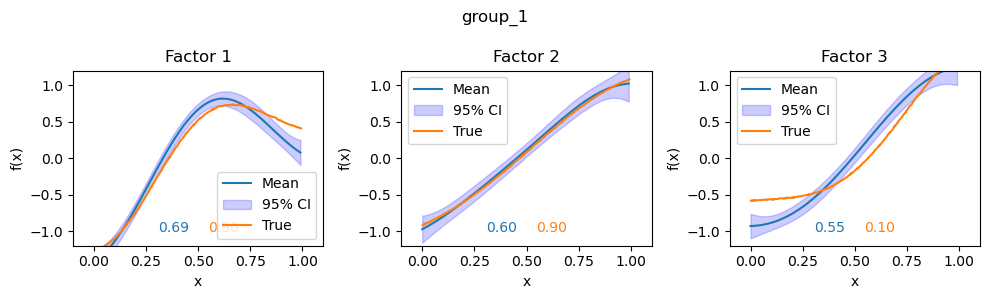

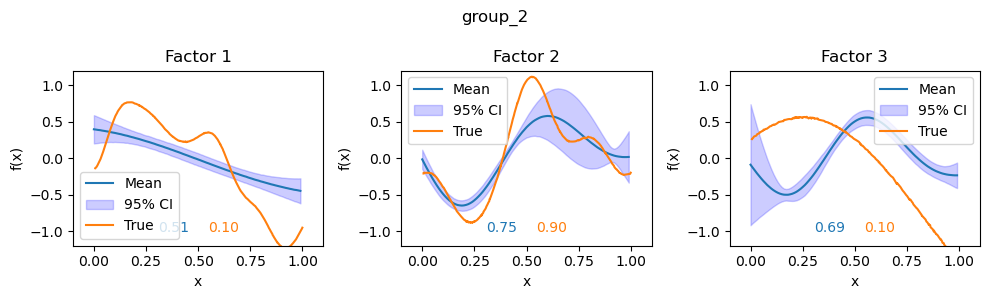

In [9]:
for group in model.group_names:
    fig, axs = plt.subplots(1, z[group].shape[1], figsize=(20, 3))
    for i in range(model.n_factors):
        plot_gp(x, f_mean[group][i], f_std[group][i], ax=axs[i])

        f_gt_normalized = (f_gt[group].iloc[:, i] - f_gt[group].iloc[:, i].mean()) / (0.5 *(f_gt[group].iloc[:, i].max() - f_gt[group].iloc[:, i].min()))
        df = pd.merge(f_gt_normalized, covariates[group], left_index=True, right_index=True)
        df.columns = ["f", "covariate"]
        df = df.sort_values("covariate")
        axs[i].plot(df["covariate"], df["f"], c="C1", label="True")
        axs[i].legend()
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-1.2, 1.2)
        axs[i].set_title(f"Factor {i+1}")
        axs[i].text(0.4, 0.1, f"{outputscales[group][i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes, color="C0")
        axs[i].text(0.6, 0.1, f"{factor_smoothness[group][i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes, color="C1")
    fig.suptitle(group)
    plt.tight_layout()

<Axes: >

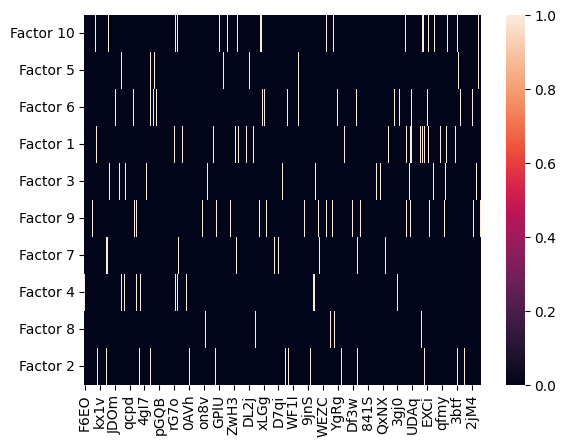

In [13]:
sns.heatmap(model.get_weights()["view_1"].abs() > 0.1)

<Axes: >

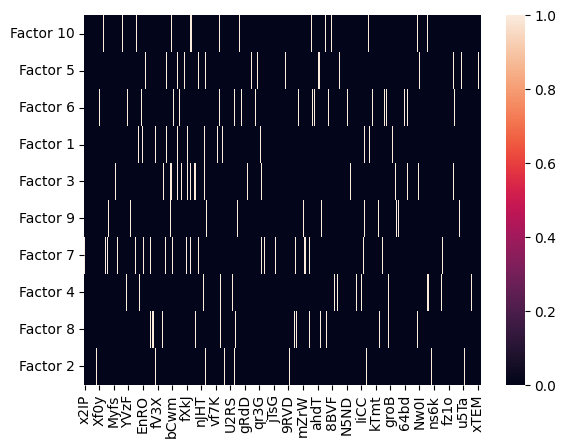

In [14]:
sns.heatmap(model.get_weights()["view_2"].abs() > 0.1)